# Assignment 6

### GROUP NUMBER : 17
### STUDENT NAMES :  Henk, Lodewijk, Nils
### STUDENT NUMBERS : 11676892, 11054115, 11784415

# Introduction
This exercise extends and builds on the results of Assignment 5. With landmark‐based localizalization from Assignment 5 relying on an a priori known map, this assignment focuses on autonomous map building, while exploring the environment. This is described in detail in in chapter 5.8 [p. 348-356]. 

In the scope of this assignment we will use the same robot described in Assignment 5, which can be described by its $x$ and $y$ coordinates and the orientation $\theta$

In [3]:
%pylab inline

from utils import *

Populating the interactive namespace from numpy and matplotlib


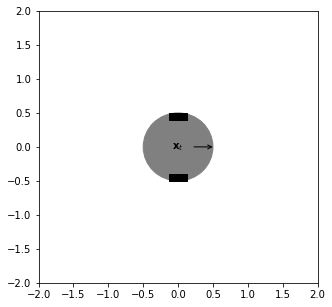

In [4]:
# Initialization of a figure
f, ax = plt.subplots(1,1, figsize=(5,5))
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

# Initial state [x,y,theta]
x_0 = [0,0,0]
# Distance between the wheels
b = 1

# Plotting function to visualize the robot
draw_robot(x=x_0, b=b, label='${\\bf x}_{t}$')

# EFK SLAM
Review Kalman Filter Localiza on and Line Parametriza on from the previous assignment. The idea behind EKF SLAM is to treat the map in a probabilistic way, similar to treating the pose of the robot. Therefore, we add the parameters $\alpha^i$ and $\rho^i$ of each landmark $m_i$ to the EKF state:
\begin{equation}
{\bf x}_t =\left[x, y, \theta, \alpha^1, \rho^1, \dots, \alpha^K, \rho^K \right]^T
\end{equation}
We assume that the landmarks do not have any dynamics, i.e. they are static in the world frame.
By properly including the landmarks in the state vector, we can now obtain the uncertainty of the landmarks as well as the correlations between them.
For the implementation of the SLAM‐filter, we assume that we know the number of landmarks and have a (very rough) estimate of them at startup. This simplifies the implementational details significantly, as no landmark book‐keeping is necessary.

At time $t-1$ the robot has access to a rough estimate of the map $M$. Each landmark ${\bf m}^i$ is associated with a mean vector $\hat{\bf m}^i=[\hat{\alpha}^i,\hat{\rho}^i]$ and a $2\times2$ covariance matrix ${ \hat{\bf P}_{m^i}}$ which expresses the corresponding uncertainty. The ground truth map (on the left) is compared with the initial robot belief (on the right) in the figure below.
Note that the expected landmarks according to the robot belief ${\bf m}^i$ are represented with solid lines, while the other semi-transparent lines in the picture are samples from the distribution $\mathcal{N}(\hat{\bf m}^i, \hat{\bf P}_{m^i})$, which represent the robot uncertainty on the landmark positions (the more sparse the samples, the less certain the robot about the map).

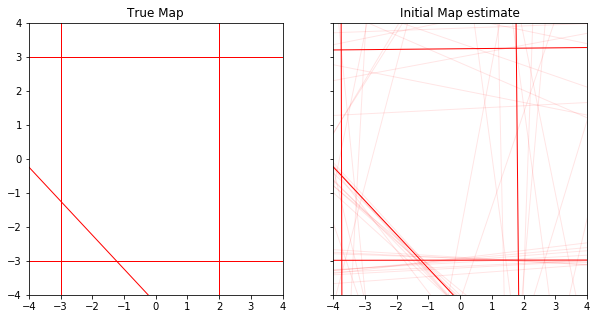

In [5]:
# Figure setup
f, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
ax[0].set_title('True Map')
ax[1].set_title('Initial Map estimate')

ax[0].set_xlim(-4,4)
ax[0].set_ylim(-4,4)

# True map (unknown to the robot)
true_M = get_default_map()

# Obtain a initial rough estimate of the map
M, P_M = get_sampled_map()

# Draw the true map on the left
draw_map(true_M, ax=ax[0], color='red')

# Draw the initial robot estimate on the right
draw_map_estimate(M, P_M, ax=ax[1], color='red')
   

Note that in the scope of this assignment, we will consider an initial estimate with low uncertaity for the first two landmarks ${\bf m}^1$ and ${\bf m}^2$ (two bottom lines in the figure above) and high uncertainty for the rest of the map.

Each landmark in the map can be alternatively represented as a point in polar coordinate space, while the robot initial map estimate can be visualized by the level sets the Gaussian distribution $\mathcal{N}(\hat{\bf m}^i, \hat{\bf P}_{m^i})$, which correspond to the initial map knowledge.

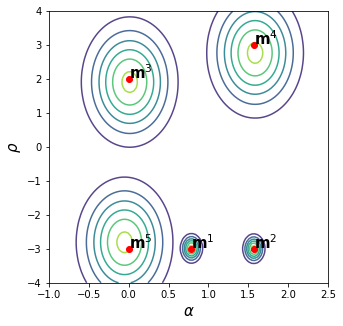

In [6]:
# Figure setup
f, ax = plt.subplots(1,1, figsize=(5,5))
ax.set_xlim(-1,2.5)
ax.set_ylim(-4,4)

# True map (unknown to the robot)
true_M = get_default_map()

# Obtain a initial rough estimate of the map (robot initial knowledge)
M, P_M = get_sampled_map()

draw_landmarks_distribution(M,P_M)
draw_landmarks(true_M, ax=ax)

## State Prediction
Assignment 5 dealt with the state propagation model of the robot when not including the landmarks in the state. As these landmarks are now part of the state vector, we have to adjust the state propagation model. Since the landmarks are considered to be static, we model them using zero velocity dynamics.
\begin{equation}
    \Delta\alpha^i = 0\\
    \Delta\rho^i = 0
\end{equation}

## Task 1 (3 Points)
Derive and implement the state prediction and covariance propagation for the state defined above, To this end, you can adapt the state transition function defined below or use your implementation from Assignment 5. The $\textit{state_transition}$ function maps the
state ${\bf x}_{t-1}$ at time $t−1$ to the state ${\bf x}_t$ given the wheel odometry ${\bf u}_t=[\Delta s_l, \Delta s_r]$ as defined in the previous assignment.
\begin{equation}
\hat{\bf x}_t = f({\bf x}_{t-1}, {\bf u}_t)
\end{equation}

Additionally, derive ${\bf F}_x$ and ${\bf F}_u$ for this formulation and implement your results in the function below.
\begin{equation}
{\bf F}_x = \frac{\partial f({\bf x}_{t-1}, {\bf u}_t)}{\partial {\bf x}} \ \ \ \ \ \ \ \  {\bf F}_u = \frac{\partial f({\bf x}_{t-1}, {\bf u}_t)}{\partial {\bf u}}
\end{equation}

In [19]:
# This function implements the transition function as defined 
# in Assignment 5, you can either start from this implementation
# or use your own

def transition_function(x, u, b): 
    '''
    Inputs:
        x: previous state at t-1
        u: control inputs
        b: wheel distance
    Return:
        x_next: estimate of the current state
        F_x: Jacobian of the transition function with respect to the state
        F_u: Jacobian of the transition function with respect to the control input
    '''
    
    ####################
    # UPDATE FROM HERE #
    ####################
    
    # Convert x and u to numpy arrays
    x = np.array(x)
    u = np.array(u)
    
    x_t = np.array([((u[0] + u[1]) / 2) * np.cos(x[2] + ((u[1] - u[0]) / 2 * b)), 
                ((u[0] + u[1]) / 2) * np.sin(x[2] + ((u[1] - u[0]) / 2 * b)),
                ((u[1] - u[0]) / b), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
                ])
    
    # Compute delta_s and delta_theta to use for the computation of F_x and F_u
    delta_s = u.mean()
    delta_theta = (u[1] - u[0]) / b
    
    # Compute the state update delta_x
    delta_x = np.array([
        delta_s * np.cos(x[2] + delta_theta / 2),
        delta_s * np.sin(x[2] + delta_theta / 2),
        delta_theta, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0   
    ])
    
    # The next state is obtained by summing the previous one with the variation delta_x
    x_next = x + delta_x
    
    # Definition of F_x
    F_x = np.eye(13)
    F_x[0,2] = -delta_s * np.sin(x[2] + delta_theta / 2)
    F_x[1,2] =  delta_s * np.cos(x[2] + delta_theta / 2)
    
    
    # Definition of F_u
    F_u = np.array([
        [
            0.5 * np.cos(x[2] + delta_theta / 2.0) + delta_s / (2 * b) * np.sin(x[2] + delta_theta / 2.0), 
            0.5 * np.cos(x[2] + delta_theta / 2.0) - delta_s / (2 * b) * np.sin(x[2] + delta_theta / 2.0)
        ],
        [
            0.5 * np.sin(x[2] + delta_theta / 2.0) - delta_s / (2 * b) * np.cos(x[2] + delta_theta / 2.0),
            0.5 * np.sin(x[2] + delta_theta / 2.0) + delta_s / (2 * b) * np.cos(x[2] + delta_theta / 2.0)
        ],
        [
            1/b,
            -1/b
        ],
                [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], 
         

    ])
    
    ###########
    # TO HERE #
    ###########
    print(F_u.shape)
    # Do not remove the following assertions and make sure your x_next, F_u and F_x shapes are correct
    assert x_next.shape == x.shape
    assert F_x.shape[1] == x.shape[0] and F_x.shape[0] == x.shape[0]
    assert F_u.shape[0] == x.shape[0] and F_u.shape[1] == u.shape[0]
    
    return x_next, F_x, F_u


Analogously to the previous assignment, we start by checking the distribution for the next state defined by $\hat{\bf x}_t$ and $\hat{\bf P}_t$ (level sets of the Gaussian distribution) coincides with the positions of the robot after performing the noisy movement specified by ${\bf u}_t$ (red dots).
Note that the state vector has dimensionality $3 + 2 \cdot 5 = 13$ and the corresponding covariance is a $[13\times13]$ matrix.

[[ 1.          0.         -1.68294197  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          1.          1.08060461  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          1.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          1.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0

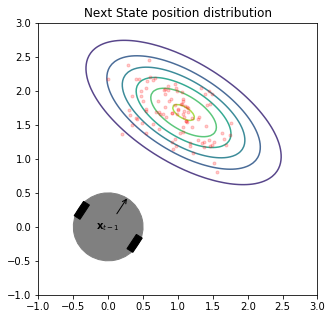

In [20]:
# NOTE: the following 2 cells do not run until you update the update_measurement function
# and your x_next, F_x and F_u have the correct shapes

from scipy.linalg import block_diag

# Set up for the matplotlib figure
f, ax = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
ax.set_title('Next State position distribution')
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)

# Distance between the wheels
b = 1

# Robot state [x, y, theta] at time t-1
x = [0,0,1]

# Covariance matrix  for state at t-1
P = np.eye(len(x)) * 0.1

# Draw the robot
draw_robot(x, b, label='${\\bf x}_{t-1}$')

# Get an initial rough estimation landmarks in polar coordinates and
# their respective covariance
M, P_M = get_sampled_map()

# Add the map to the current state
# Note that x has now size [13] while P is a [13 x 13] matrix
x = np.concatenate([x] + M, 0)
P = block_diag(*([P] + P_M))


# Amount of desired displacement for the two wheels [left_wheel, right_wheel]
# You can change this two values to test your function
u = [2., 2]

# Amount of noise for the robot movement
k = 0.05

# Perform N=100 experiments by initializing the robot at state x and performing the noisy movement
draw_simulation(x[:3], P[:3,:3], u, k, b, N=100)

# Use transition_function to determine the estimated next state and the Jacobians F_x and F_u
x_next, F_x, F_u = transition_function(x, u, b)

# Determine the covariance matrix for the nosy movement Q following Equation (2) Assignment 5
Q = compute_Q(u, k)

# The covariance at time t is obtained using Equation (3) Assignment 5
P_next = F_x @ P @ F_x.T + F_u @ Q @ F_u.T

# Draw the distribution corresponding to the next state
draw_state_distribution(x_next, P_next)

Secondly we visualize how the landmarks in the robot state are updated by plotting their distribution in polar coordinates for both ${\bf x}_{t-1}$ and ${\bf x}_t$:

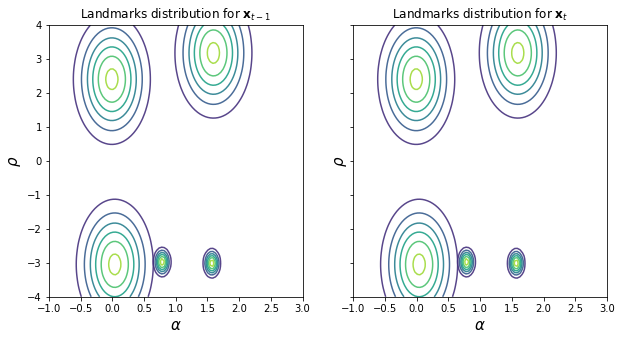

In [17]:
# Figure setup
f, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
ax[0].set_title('Landmarks distribution for ${\\bf x}_{t-1}$')
ax[1].set_title('Landmarks distribution for ${\\bf x}_{t}$')
ax[0].set_xlim(-1,3)
ax[0].set_ylim(-4,4)

# Draw the landmarks distribution before the update on the left
draw_landmarks_distribution(x[3:],P[3:, 3:], ax=ax[0])

# Draw the landmarks distribution after the update on the right
draw_landmarks_distribution(x_next[3:],P_next[3:, 3:], ax=ax[1])

$\textit{Hint:}$
1. Should the predictive distribution for $x$, $y$ and $\theta$ differ from the EFK implementation used for Assignemnt 5?
2. Does the robot change its uncertainty regarding the landmarks just by performing some movement? Should the landmarks distribution change for the new state ${\bf x}_t$?

Try to answer answer this question and reason about your results before proceeding to $\textbf{Task 4}$

## Measurement function

The main work of EKF SLAM is done in the measurement update. We assume that all landmarks are visible, and that the number of landmarks does not change. This is not a limitation, but it simplifies implementation and debugging effort at this stage. Measurement association and update work similarly to Exercise 4, except that the measurement Jacobians ${\bf H}^i$ need special attention. We can show that the relative position and heading of the robot with respect to the landmarks can be estimated. However, the global position and heading of the robot as well as the landmarks is not observable. This can be intuitively explained by the fact that if both robot and landmarks are moved or rotated by the same amount simultaneously,
we cannot detect this motion using only relative distance or bearing measurements of the robot with respect to the walls or wheel encoder information. To eliminate these degrees of freedom, we fix the first two landmarks in the state vector (assuming that both walls are not parallel), in order to fully constrain the unobservable states.

### Task 2 (4 Points)
Based on the implementation in Assignment 5, implement a measurement function that returns the predicted measurement given the state vector (which is now including both robot state and landmarks) and the landmark index as defined in the following equation. To this end, update $\textit{measurement_function}$ (Hint: What has actually changed since the previous exercise?).
\begin{equation}
    \hat{\bf z}^i_t = h^i(\hat{\bf x}_t)
\end{equation}
Additionally, provide the corresponding Jacobian of the measurement with respect to the state vector $\hat{\bf H}_x$. Compared to Assignment 5, the landmark position is now part of the state vector. This has to be reflected in the computation of the Jacobian.
\begin{equation}
    \hat{\bf H}_x^i = \frac{\partial h^i(\hat{\bf x}_t)}{\partial {\bf x}}
\end{equation}

In [ ]:
def measurement_function(x, i):
    '''
    Inputs:
        x: estimate of the state at time t
        i: landmark id
    Return:
        z: measurement as perceived by a robot with state x
        H: Jacobian of the measurement model with respect to the state
    '''
    
    ####################
    # UPDATE FROM HERE #
    ####################
    
    # NOTE: The old implementation received a landmark m as an input
    # while in this case the input 'i' is a landmark id within the state x
    # What is the new m?
    
    # Convert x to a numpy array
    x = np.array(x)
   
    # Compute the expected measurement z 
    z = [
        m[0]-x[2], 
        m[1]-(x[0]*np.cos(m[0])+x[1]*np.sin(m[0]))
    ]
    
    # And the measurement Jacobian H
    H = [
        [0, 0, -1],
        [-np.cos(m[0]), -np.sin(m[0]), 0]
    ]
    
    # Convert them to numpy arrays
    z = np.array(z)
    H = np.array(H)
    
    ###########
    # TO HERE #
    ###########
    
    return z, H

We visualize the result of your implementation analogously to the previous assignment by first showing the robot landmarks estimate $\hat{\bf m}^i_t$ (red lines on the left picture), then comparing the output of the measurement function $\hat{\bf z}_t^i$ (red lines on the right picture) with the actual sensor readings ${\bf z}^j_t$ (dashed blue lines on the right) at time $t$.

In [ ]:
# NOTE: this cell does not run until you update the measurement_function function
# and your z and H have the correct shapes

# Figure Setup
f, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].set_title("World Coordinates")
ax[0].set_xlim(-4,4)
ax[0].set_ylim(-4,4)

ax[1].set_title("Body Coordinates")
ax[1].set_xlim(-4,4)
ax[1].set_ylim(-4,4)

# Distance between the wheels
b = 1

# Robot state [x, y, theta] at time t-1
x = [0,0,1]

# Covariance matrix  for state at t-1
P = np.eye(len(x)) * 0.1

# Draw the robot on the two subplots
draw_robot(x, b, label='${\\bf x}_t$', ax=ax[0]) # World coordinates
draw_robot([0,0,0], b, label='${\\bf x}_t$', ax=ax[1]) # Body frame coordinates

# Get an initial rough estimation landmarks in polar coordinates and
# their respective covariance
M, P_M = get_sampled_map()

# True map (unknown to the robot)
true_M = get_default_map()

# Add the map to the current state
x = np.concatenate([x] + M, 0)
P = block_diag(*([P] + P_M))

# Draw the map in world coordinates on the first picture
draw_map(M, ax=ax[0])

# Initialize an empty map in robot body coordinate frame
robot_M = [] 

# Use the measurement_function to convert the global coordinates m into local ones z
for i in range(len(M)):
    z, H = measurement_function(x, i)
    robot_M.append(z)


# Draw the map in body frame coordinates on the second picture
draw_map(robot_M, ax=ax[1])

# Take some measurements Z using the robot sensors
Z, R = make_measurements(x, true_M)

# Draw the robot measurements on the second picture
draw_map(Z,  color='blue', dashed=True, ax=ax[1], alpha=0.6)

$\textit{Hint:}$ 
Make sure that the estimated landmarks $\hat{\bf m}^i_t$ are correctly converted from world to body frame coordinates. Note that, in contrast to Assignment 5, the robot measurements ${\bf z}^j_t$ (in blue on the right) do not necessarily overlap with the robot estimated measurements $\hat{\bf z}^i_t$ (in red on the right) since the robot has only approximate knowledge about the map.

Make sure your implementation is correct before progressing to the $\textbf{Task 3}$

## Measurement association
Analogously to the previous assignment, the predicted measurements $\hat{\bf z}^i_t$ need to be associated to the actual measurements ${\bf z}^j_t$. This is done by first computing a distance metric $d_t^{ij}$, then associating each measurement to the closest predicted measurement whenever their distance falls in the interval defined by the validation gate $g$.


### Task 3 (1 point)
Adapt the implementation of the $\textit{associate_measurements}$ function from the previous exercise considering that the estimated landmark $\hat{\bf m}^i_t$ are now part of the state vector $\hat{\bf x}_t$.
The output and behaviour of this function should be unchanged when compared to the previous assignment.
Once again you can either adapt the implementation below or use your own.

In [ ]:
def associate_measurements(x,P,Z,R,g):
    '''
    Inputs:
        x: estimate of the state at time t
        P: covariance of the state estimate
        Z: list of measurements 
        R: list of covariance matrices corresponding to the measurements (R[i] is the covariance for Z[i])
        g: validation gate
    Return:
        a: vector of associations between measurements and map entries
    '''
    ####################
    # UPDATE FROM HERE #
    ####################
    
    # NOTE: In contrast with the previous assignment, the map M is not given as an input
    # since the landmarks are included in the state x
    
    # Instantiate an empty distance matrix ds with size [len(Z) x len(M)]
    d = np.zeros([len(Z), len(M)])
    
    # For each measurement id 'i'
    for i in range(len(Z)):
        
        # For each landmark id 'j'
        for j in range(len(M)):
            
            # Consider the i-th measurement
            z = Z[i]
            R_i = R[i]
            
            # Consider the j-th landmark
            m = M[j]
            
            # Compute the predicted measurement z_hat and the measurement Jacobian H
            # NOTE: Keep in mind that the new implementation of measurement_function uses the
            # landmark id instead of the landmark vector 'm'
            z_hat, H = measurement_function(x, m)
            
            # Compute the innoviation vector v
            v = z - z_hat
            
            # Compute the covariance Sigma
            Sigma = (H @ P @ H.T) + R_i
            
            # And use it to determine the distance d_ij
            Sigma_inv = np.linalg.inv(Sigma)
            d_ij = v.T @ Sigma_inv @ innovation
            
            # Set the entry in the distance matrix d to its corresponding value
            d[i,j] = d_ij
    
    # Set the distance exceding g^2 to positive infinity
    d[d > g**2] = np.inf
    
    # Identify the minimum for each column
    min_values = np.amin(d, 1)
    
    # The assignment vector is determined by the id of the minumum for each column
    a = np.argmin(d, 1)
    
    # Replace the id of all the assignment that have been distarded by the validation gate to -1 
    a[min_values == np.inf] = -1
    
    ###########
    # TO HERE #
    ###########

    return a 

The association vector $\bf a$ obtained by calling your implementation of $\textit{associate_measurements}$ is shown below. Each measurement is coloured according to the associated landmark and left black if its minumum distance is grater then the threshold specified by the validation gate:

In [ ]:
# NOTE: this cell does not run correctly until you update measurement_function and associate_measurements

# Figure setup
f, ax = plt.subplots(1,1, figsize=(5,5))
ax.set_title("Body Coordinates")
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)

# Distance between the wheels
b = 1

# Robot state [x, y, theta] at time t-1
x = [0,0,1]

# Covariance matrix  for state at t-1
P = np.eye(len(x)) * 0.1

# Draw the robot on the two subplots
draw_robot(x, b, label='${\\bf x}_t$') # World coordinates

# Get an initial rough estimation landmarks in polar coordinates and
# their respective covariance
M, P_M = get_sampled_map()

# True map (unknown to the robot)
true_M = get_default_map()

# Add the map to the current state
x = np.concatenate([x] + M, 0)
P = block_diag(*([P] + P_M))

# Validation gate g
g = 1

# Use the measurement_function to convert the landmarks m into local coordinates z
robot_M = [] 
for i in range(len(M)):
    z, _ = measurement_function(x, i)
    robot_M.append(z)
    
    
# Take some measurements Z using the robot sensors
Z, R = make_measurements(x, true_M)

# Determine the association between measurement and map entries
a = associate_measurements(x, P, Z, R, g)

# Draw each line in the map and its associated measurements with the same color
# Note: Make sure your measurement_function is correct first
draw_associations(robot_M, Z, a)

$\textit{Hint:}$
Make sure your implementation is working before progressing to $\textbf {Task 4}$.

## Updating the estimate

As a last step to implement the SLAM Extended Kalman Filter procedure, we need to update the robot state according to the measurements. In order to do so we can use the same procedure used for the standard Extended Kalman filter, which now will update both the estimate robot position and the landmarks  in the robot state ${\bf x}_t$.

### Task 4 (2 Points)
Adapt the a $\textit{filter_step}$ and $\textit{compute_innovation}$ functions to read the map directly from the robot state $\hat{\bf x}_t$ instead of a map ${\bf M}$ as given in Assigment 5. You can either adapt the code provided below or write your own implementation:

In [ ]:
from scipy.linalg import block_diag


def compute_innovation(x, Z_all, R_all, a):
    '''
    Input:
        x: the estimated robot state at time t
        Z_all: list of robot measurements at time t
        R_all: list of covariance matrices corresponding to the measurements in Z_all
        a: measurement-map association vector (as defined in the previous section)
    Returns:
        v: list of innovation vectors
        filtered_H: list of Jacobians H (one for each innovation)
        filtered_R: list of Covariance matrices R (one for each innovation)
    ''' 
    
    ####################
    # UPDATE FROM HERE #
    ####################
    
    # NOTE: The previous implementation received the map M as an input

    v = []
    filtered_R = []
    filtered_H = []
    
    # For each assignment
    for i in range(len(a)):
        
        # If the value is not -1 (the association has not been filtered by the validation gate)
        if a[i] >= 0:
            
            # Compute the expected measurement (robot body coordinates) and its Jacobian
            z_hat, H = measurement_function(x, M[a[i]])
            
            # Compute the innovation vector
            v_i = Z_all[i] - z_hat
            
            # Add the innovation v_i, the Jacobian H and the covariance R to their respective list 
            v.append(v_i)
            filtered_R.append(R_all[i])
            filtered_H.append(H)
            
    ###########
    # TO HERE #
    ###########
            
    return v, filtered_H, filtered_R



def filter_step(x, P, u, k, Z, R, g, b):
    '''
    Input:
        x: robot state at time t-1
        P: covariance matrix corresponding to the robot state at time t-1
        u: control inputs
        k: displacement noise factor (see Equation (2))
        Z: list of robot measurements at time t
        R: list of covariance matrices corresponding to the measurements in Z
        g: validation gate
        b: distance between the wheels
    Returns:
        x_next: corrected estimation for the robot state at time t
        P_next: corrected covariance corresponding to x_next
    '''
    
    ####################
    # UPDATE FROM HERE #
    ####################
    
    # NOTE: The previous implementation received the map M as an input
    
    # Compute the next x together with the two Jacobians F_x and F_u using the
    # previously implemented 'transition_function'
    x_next, F_x, F_u = transition_function(x, u, b)
    
    # Build the covariance matrix following Equation (2)
    Q = compute_Q(u, k)
    
    # Compute the covariance matrix for the next state using Equation (3)
    P_next = F_x @ P @ F_x.T + F_u @ Q @ F_u.T
    
    # Use the 'associate_measurements' to determine which map entries correspond
    # to the measurements Z
    # Note: The new associate_measurements function does not get the map M 
    # as an input
    a = associate_measurements(x_next, P_next, Z, R, M, g)
    
    # compute the list of innovations
    # NOTE: your updated implementation of compute_innovation does not
    # have access the map M
    v, H, R = compute_innovation(x_next, Z, R, M, a)
    
    if len(v) > 0:
        # Concatenate the innoviation vectors,
        v = np.concatenate(v, 0)
        
        # the measurement Jacobians
        H = np.concatenate(H, 0)
        
        # and make a block diagonal covariance matrix R
        R = block_diag(*R)
        
        # Compute the covariance Sigma
        Sigma = H @ P_next @ H.T + R
        
        # And use it to compute the Kalman matrix K
        Sigma_inv = np.linalg.inv(Sigma)
        K = P_next @ H.T @ Sigma_inv
        
        # Then use K to compute the correction to the next state distribution
        x_next += K @ v
        P_next -= K @ Sigma @ K.T 
        
    ###########
    # TO HERE #
    ###########
    
    return x_next, P_next

First we check how the robot position is by the Kalman Filter correction by comparing the distribution of the robot position before (on the left) and after (on the right) considering the measurements as in the previous assignment. $\textit{Hint:}$ Do we expect anything to change with respect to the previous assignment here?

In [ ]:
# NOTE: this cell does not run correctly until you update the filter_step function

# Figure setup
f, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
ax[0].set_title('Estimated position before measurement')
ax[1].set_title('Estimated position after measurement')
ax[0].set_xlim(-4,4)
ax[0].set_ylim(-4,4)

# Distance between the wheels
b = 1

# Robot state [x, y, theta] at time t-1
x = [0,0,1]

# Covariance matrix  for state at t-1
P = np.eye(len(x)) * 0.1

# Get an initial rough estimation landmarks in polar coordinates and
# their respective covariance
M, P_M = get_sampled_map()
true_M = get_default_map()

# Add the map to the current state
x = np.concatenate([x] + M, 0)
P = block_diag(*([P] + P_M))

# Draw the robot at time t-1 on both Axis
draw_robot(x, b, label='${\\bf x}_{t-1}$', alpha=1, ax=ax[0])
draw_robot(x, b, label='${\\bf x}_{t-1}$', alpha=1, ax=ax[1])

# Amount of desired displacement for the two wheels [left_wheel, right_wheel]
u = [2, 2]

# Amount of noise in the robot movement see Equation (2)
k = 0.02

# Validation gate
g = 1

# Draw the map on the two figures
draw_map(true_M, ax=ax[0])
draw_map(true_M, ax=ax[1])

# The actual initial robot position is sampled from the distribution at time t
x_actual = np.random.multivariate_normal(mean=x[:3], cov=P[:3,:3])

# The position of the robot at the next timestamp is determined by executing the displacement determined by u
x_next = execute_instruction(x=x[:3], u=u, b=b, k=k)

# Draw the robot at its actual position (noisy) at time t 
draw_robot(x_next, ax=ax[0], label='${\\bf x}_{t}$', b=1, alpha=0.5)
draw_robot(x_next, ax=ax[1], label='${\\bf x}_{t}$', b=1, alpha=0.5)

# Determine the expected new position according to the transition function
x_next_est, F_x, F_u = transition_function(x, u, b)

# And compute its covariance matrix following Equation (2) and Equation (3)
Q = compute_Q(u, k)
P_next_est = F_x @ P @ F_x.T + F_u @ Q @ F_u.T

# Draw the distribution for the state at time t on the figure on the left
draw_state_distribution(x_next_est, P_next_est, ax=ax[0])

# Make some measurements in the current position
Z, R =  make_measurements(x_next, true_M)

# Use the implementation of Kalman filter to determine how to update x_next and P_next
x_next_kalman, P_next_kalman = filter_step(x, P, u, k, Z, R, g, b)

# Draw the distribution for the robot position after adjusting the estimates using the sensor input
draw_state_distribution(x_next_kalman, P_next_kalman, ax=ax[1])

#draw_map_estimate(x[3:], P[3:,3:], ax=ax[0], color='blue')
#draw_map_estimate(x_next_kalman[3:], P_next_kalman[3:,3:], ax=ax[1], color='blue')


Secondly, we visualize how the landmark position is updated after performing the measurement. We can do so by comparing the estimated landmarks (in blue) before $\hat{\bf m}^i_{t-1}$ (on the left) and after $\hat{\bf m}^i_{t}$ the update (on the right). The ground truth map is shown with red solid lines.

In [ ]:
# Figure setup
f, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
ax[0].set_title('Estimated map before measurement')
ax[1].set_title('Estimated map after measurement')
ax[0].set_xlim(-4,4)
ax[0].set_ylim(-4,4)

# Draw the map on the two figures
draw_map(true_M, ax=ax[0])
draw_map(true_M, ax=ax[1])

# Draw the landmark estimate before the update on the left
draw_map_estimate(x[3:], P[3:,3:], ax=ax[0], color='blue', alpha=0.2)
# Draw the landmark estimate after the update on the right
draw_map_estimate(x_next_kalman[3:], P_next_kalman[3:,3:], ax=ax[1], color='blue', alpha=0.2)

The same comparison can be performed directly in polar coordinates, in which the landmark estimates are represented as Gaussian distributions, while red dots are used to visualize the ground truth representation of the landmarks.

In [ ]:
# Figure Setup
f, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
ax[0].set_title('Estimated map before measurement')
ax[1].set_title('Estimated map after measurement')
ax[0].set_xlim(-1,3)
ax[0].set_ylim(-4,4)
        
# Draw the ground truth landmarks as points in polar coordinates on the two pictures
draw_landmarks(true_M, ax=ax[0])
draw_landmarks(true_M, ax=ax[1])

# Draw the landmark distribution before the update on the left
draw_landmarks_distribution(x[3:],P[3:, 3:], ax=ax[0])
# Draw the landmark distribution after the update on the right
draw_landmarks_distribution(x_next_kalman[3:],P_next_kalman[3:, 3:], ax=ax[1])

$\textit{Hint:}$ When your implementation is correct, the landmark distribution should shrink and focus on the position of the ground truth landmarks.
You can check the correctness of your implementation by changing some parameters such as the robot state ${\bf x}_{t-1}$, the displacement vector ${\bf u}_t$ and the value of the validation gate $g$. If the landmarks distribution does not get updated correctly, try to check your measurement Jacobian $\hat{\bf H}_x$.